## STAT451 Project: IMDb movie review classification and prediction

**Group 12: Shuyuan Jia, Isabella Xue, Freya Wan**

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load dataset
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

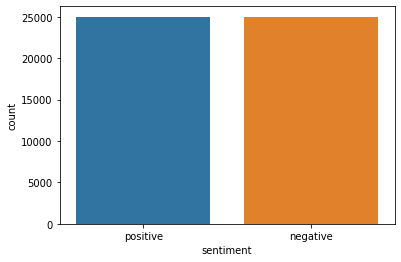

In [4]:
import seaborn as sn
sn.countplot(x="sentiment",data=df)

In [5]:
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

We can see that this dataset is balanced. The number of positive reviews and negative reviews are equal.

**Data Cleaning**

In [6]:
#!pip install contractions
import contractions  # This package is used to replace the contractions in English language with their actual forms
from tqdm import tqdm  # tqdm is used to display the percentage of work done by a for loop.
import nltk
import re
import time
#nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
# Removing stopwords 'no','nor' and 'not'
stopwords.remove('no')
stopwords.remove('nor')
stopwords.remove('not')

df['label'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.head(5)

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [7]:
clean_reviews=[]

for i in tqdm(df['review']):
    # Removes all the html tags pressent in the reviews
    i = re.sub('(<[\w\s]*/?>)',"",i)
    # Expand all the contractions present in the review to is respective actual form
    i = contractions.fix(i)
    # Remove all special characters from the review text
    i = re.sub('[^a-zA-Z0-9\s]+',"",i)
    # Remove all the digits present in the review text
    i = re.sub('\d+',"",i)
    # Put the clean reviews to clean_reviews
    clean_reviews.append(" ".join([j.lower() for j in i.split() if j not in stopwords and len(j)>=3]))

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:32<00:00, 1551.34it/s]


In [8]:
# Create a new datafram using the clean_reviews
new_clean_df = pd.DataFrame({'review':clean_reviews,'label':list(df['label'])})
new_clean_df.head()

,review,label
0,one reviewers mentioned watching episode hooke...,1
1,wonderful little production the filming techni...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter matteis love time money visually stunni...,1


In [9]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def stemmer(text):
    final = [porter.stem(word) for word in text.split()]
    return final

In [10]:
# vectoring by using tf-idf
# TfidfVectorizer, which combines CountVectorizer with the TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(strip_accents = None, lowercase = False, tokenizer = stemmer, use_idf = True, norm ='l2',smooth_idf = True )

In [11]:
Y = new_clean_df['label']
X = tfidf.fit_transform(new_clean_df.review)

In [12]:
# Split the data: 
# 33% data will be used for testing and 67% will be used for training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X, Y, stratify = Y, test_size = 0.33)

## Neural Network Models

**Dense model**

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping

In [14]:
## Out of 50k dataset: 26800 for training, 6700 for validation and 16500 for testing

X_train, X_test, y_train, y_test = train_test_split(new_clean_df['review'], new_clean_df['label'], 
                                                    test_size=0.33, random_state= 123)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state= 123) 


In [15]:
[x.shape for x in [X_train,X_valid,X_test]]

[(26800,), (6700,), (16500,)]

In [16]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(new_clean_df.review)+

X_train_int = tokenizer.texts_to_sequences(X_train)
X_valid_int = tokenizer.texts_to_sequences(X_valid)
X_test_int = tokenizer.texts_to_sequences(X_test)
token_size = len(tokenizer.word_index) + 1  # Add 1 because of reserved 0 index

In [17]:
sequence_lens = [len(i) for i in X_train_int]
print("average length: %0.1f" % np.mean(sequence_lens))
print("max length: %d" % max(sequence_lens))

average length: 98.5
max length: 796


In [18]:
MAXLEN = 250
X_train_int = pad_sequences(X_train_int, padding='post', maxlen= MAXLEN)
X_valid_int = pad_sequences(X_valid_int, padding='post', maxlen= MAXLEN)
X_test_int = pad_sequences(X_test_int, padding='post', maxlen= MAXLEN)

In [19]:
import keras
from keras.preprocessing import text, sequence
import pandas as pd
import numpy as np
from keras import models, layers

MAXLEN = 250
DIM = 50
callback = EarlyStopping(monitor='val_loss', patience = 2)

# Define the keras model
model = models.Sequential()
model.add(layers.Embedding(input_dim = token_size, output_dim= DIM, input_length= MAXLEN))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the keras model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 50)           10637300  
                                                                 
 flatten (Flatten)           (None, 12500)             0         
                                                                 
 dense (Dense)               (None, 10)                125010    
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10,762,321
Trainable params: 10,762,321
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fit the keras model on the dataset

history = model.fit(X_train_int, y_train,
                    epochs=10, verbose=True,
                    validation_data=(X_valid_int, y_valid),
                    batch_size=1000, callbacks=[callback])


Epoch 1/10
27/27 [==============================] - 5s 180ms/step - loss: 0.6928 - accuracy: 0.5103 - val_loss: 0.6916 - val_accuracy: 0.5231
Epoch 2/10
27/27 [==============================] - 5s 171ms/step - loss: 0.6733 - accuracy: 0.5548 - val_loss: 0.6319 - val_accuracy: 0.5779
Epoch 3/10
27/27 [==============================] - 5s 170ms/step - loss: 0.4494 - accuracy: 0.7912 - val_loss: 0.3291 - val_accuracy: 0.8625
Epoch 4/10
27/27 [==============================] - 5s 169ms/step - loss: 0.2560 - accuracy: 0.8988 - val_loss: 0.2948 - val_accuracy: 0.8804
Epoch 5/10
27/27 [==============================] - 5s 168ms/step - loss: 0.1895 - accuracy: 0.9306 - val_loss: 0.2968 - val_accuracy: 0.8796
Epoch 6/10
27/27 [==============================] - 5s 170ms/step - loss: 0.1466 - accuracy: 0.9522 - val_loss: 0.3021 - val_accuracy: 0.8807


In [21]:
model.evaluate(X_test_int, y_test)

516/516 [==============================] - 1s 2ms/step - loss: 0.3052 - accuracy: 0.8773


[0.3051522970199585, 0.8772727251052856]

In [22]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test_int)
y_pred = np.round(y_pred).astype(int)
f1_score(y_test, y_pred)

0.8783126014061655

In [23]:
from matplotlib import pyplot as plt

def accuracy_plot(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    x = range(1, len(train_acc) + 1)
    plt.plot(x, train_acc, 'green', label='Training Acc')
    plt.plot(x, val_acc, 'orange', label='Validation Acc')
    plt.title('Training Acc vs. Validation Acc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    
def loss_plot(history):
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(train_acc) + 1)
    plt.plot(x, train_loss, 'green', label='Training loss')
    plt.plot(x, val_loss, 'orange', label='Validation loss')
    plt.title('Training Loss vs. Validation Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()


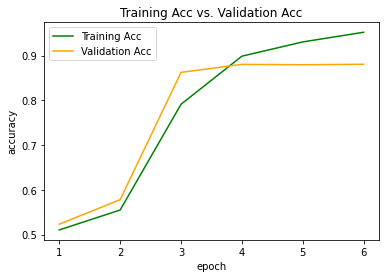

In [24]:
accuracy_plot(history)

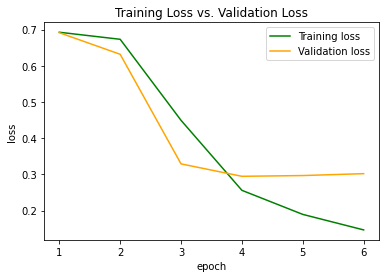

In [25]:
loss_plot(history)

**LSTM**

In [33]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow as tf
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from gensim.models import KeyedVectors

MAXLEN = 250
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=token_size, output_dim= 32, input_length= 250))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 32)           6807872   
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,816,225
Trainable params: 6,816,225
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
history = model.fit(X_train_int, y_train, epochs=10,verbose=True,
                    validation_data=(X_valid_int, y_valid),batch_size=100,callbacks=[callback])

Epoch 1/10
268/268 [==============================] - 61s 215ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.5018
Epoch 2/10
268/268 [==============================] - 56s 210ms/step - loss: 0.6901 - accuracy: 0.5193 - val_loss: 0.6862 - val_accuracy: 0.5246
Epoch 3/10
268/268 [==============================] - 57s 211ms/step - loss: 0.6451 - accuracy: 0.6241 - val_loss: 0.6009 - val_accuracy: 0.7046
Epoch 4/10
268/268 [==============================] - 51s 192ms/step - loss: 0.5531 - accuracy: 0.7528 - val_loss: 0.5431 - val_accuracy: 0.7660
Epoch 5/10
268/268 [==============================] - 45s 169ms/step - loss: 0.5512 - accuracy: 0.7507 - val_loss: 0.5660 - val_accuracy: 0.7422
Epoch 6/10
268/268 [==============================] - 45s 169ms/step - loss: 0.5336 - accuracy: 0.7682 - val_loss: 0.5471 - val_accuracy: 0.7578


In [35]:
from sklearn.metrics import f1_score

model.evaluate(X_test_int, y_test)

516/516 [==============================] - 10s 19ms/step - loss: 0.5532 - accuracy: 0.7557


[0.5531790852546692, 0.7556969523429871]

In [36]:
y_pred = model.predict(X_test_int)
y_pred = np.round(y_pred).astype(int)
f1_score(y_test, y_pred)

0.7391782594629568

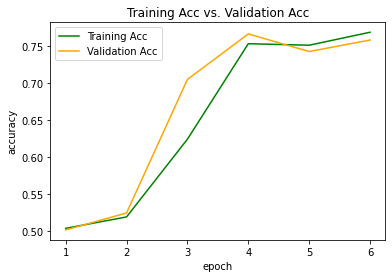

In [37]:
accuracy_plot(history)

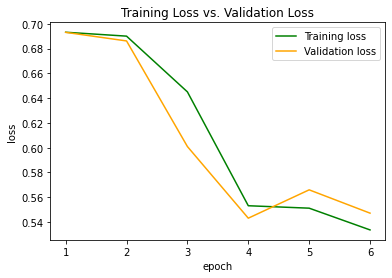

In [38]:
loss_plot(history)

**Add more layers**

In [39]:
DIM = 128
MAXLEN = 250
model = Sequential()
model.add(Embedding(input_dim=token_size, output_dim= DIM, input_length=MAXLEN))
model.add(Bidirectional(LSTM(32, return_sequences = True))) # biLSTM, is a sequence processing model that consists of two LSTMs
model.add(GlobalMaxPool1D()) 
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 128)          27231488  
                                                                 
 bidirectional_1 (Bidirectio  (None, 250, 64)          41216     
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 20)                1300      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [40]:
model.fit(X_train_int, y_train, epochs=5, batch_size=100,
          verbose = 1, validation_data=(X_valid_int,y_valid), callbacks=[callback])

Epoch 1/5
268/268 [==============================] - 122s 446ms/step - loss: 0.4056 - accuracy: 0.8125 - val_loss: 0.2930 - val_accuracy: 0.8767
Epoch 2/5
268/268 [==============================] - 115s 431ms/step - loss: 0.2333 - accuracy: 0.9078 - val_loss: 0.2780 - val_accuracy: 0.8827
Epoch 3/5
268/268 [==============================] - 114s 426ms/step - loss: 0.1845 - accuracy: 0.9301 - val_loss: 0.3232 - val_accuracy: 0.8794
Epoch 4/5
268/268 [==============================] - 118s 439ms/step - loss: 0.1411 - accuracy: 0.9492 - val_loss: 0.3325 - val_accuracy: 0.8728


In [41]:
model.evaluate(X_test_int, y_test)

516/516 [==============================] - 14s 26ms/step - loss: 0.3367 - accuracy: 0.8727


[0.33669963479042053, 0.8726666569709778]

In [42]:
y_pred = model.predict(X_test_int)
y_pred = np.round(y_pred).astype(int)
f1_score(y_test, y_pred)

0.8765642441689678

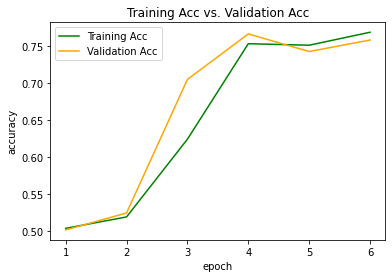

In [43]:
accuracy_plot(history)

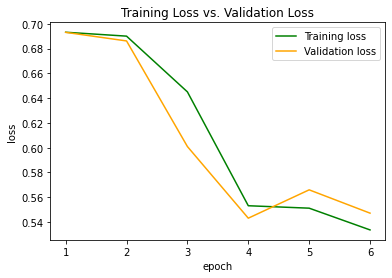

In [44]:
loss_plot(history)